In [279]:
#Data Analysis and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


In [280]:
#Reading the data
train_proteins = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_clinical = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
train_peptides = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")

In [281]:
train_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [282]:
train_proteins['UniProt'].value_counts()

P01024    1113
P05090    1113
P01011    1113
P01023    1113
Q92520    1113
          ... 
Q6UX71     661
P01780     654
Q562R1     616
Q99832     606
Q99829     489
Name: UniProt, Length: 227, dtype: int64

In [283]:
#Find the UniProt with the most data
train_proteins['UniProt'].value_counts().idxmax()

'P01024'

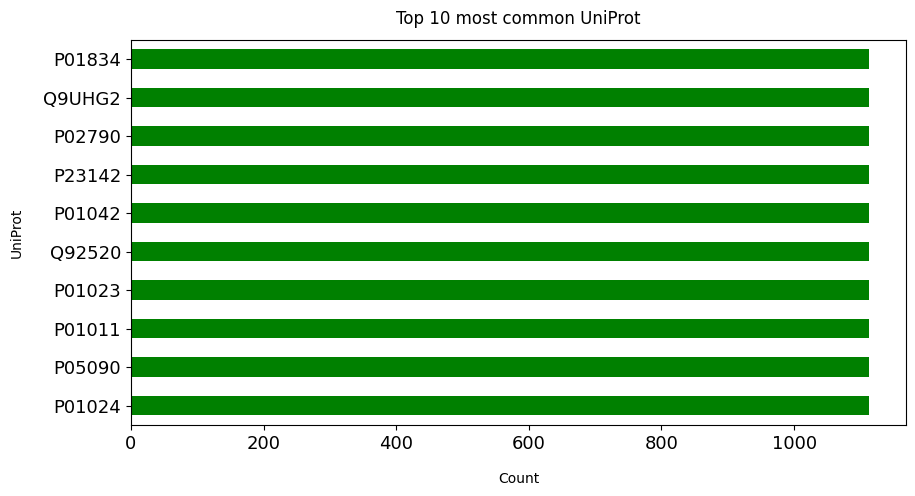

In [284]:
#Create a graph with 10 most common UniProt
train_proteins['UniProt'].value_counts().head(10).plot(kind='barh', figsize=(10,5), color='green', fontsize=13)
plt.xlabel("Count", labelpad=14)
plt.ylabel("UniProt", labelpad=14)
plt.title("Top 10 most common UniProt", y=1.02);

#Save into a png file
plt.savefig('Top10UniProt.png')





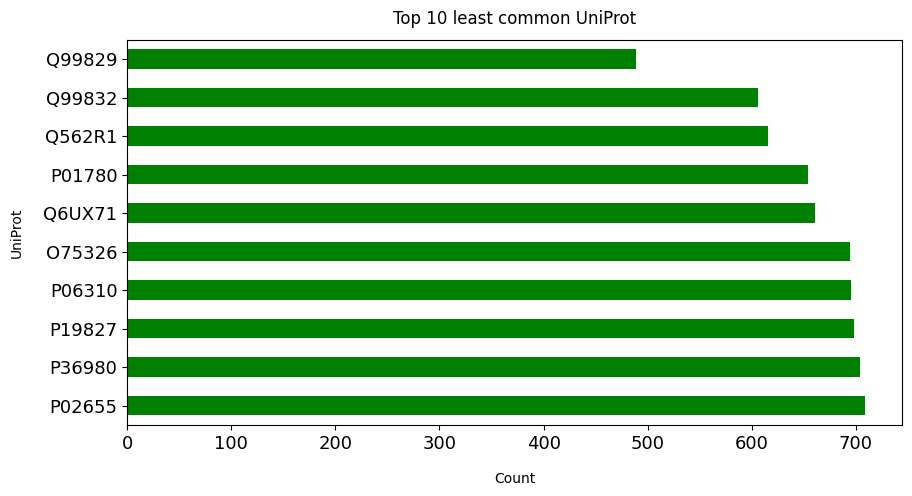

In [285]:
#Create a graph with 10 least common UniProt
train_proteins['UniProt'].value_counts().tail(10).plot(kind='barh', figsize=(10,5), color='green', fontsize=13)
plt.xlabel("Count", labelpad=14)
plt.ylabel("UniProt", labelpad=14)
plt.title("Top 10 least common UniProt", y=1.02);

#Save into a png file
plt.savefig('Bottom10UniProt.png')

In [296]:
#Get a full list of UniProt
train_proteins['UniProt'].value_counts().index.tolist()

#Pass list into a df
df_prot_list = pd.DataFrame(train_proteins['UniProt'].value_counts().index.tolist(), columns=['UniProt'])

#Create a new column with the count of each UniProt
df_prot_list['Count'] = train_proteins['UniProt'].value_counts().tolist()

#Sort the df by the count
df_prot_list.sort_values(by=['Count'], inplace=True)

#create a csv file with the list of UniProt and their count
df_prot_list.to_csv('UniProtList.csv', index=False)


In [286]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm

import plotly.express as px

#import amp_pd_peptide

from scipy.optimize import minimize

In [287]:
def smape_plus_1(y_true, y_pred):
    y_true_plus_1 = y_true + 1
    y_pred_plus_1 = y_pred + 1
    metric = np.zeros(len(y_true_plus_1))
    
    numerator = np.abs(y_true_plus_1 - y_pred_plus_1)
    denominator = ((np.abs(y_true_plus_1) + np.abs(y_pred_plus_1)) / 2)
    
    mask_not_zeros = (y_true_plus_1 != 0) | (y_pred_plus_1 != 0)
    metric[mask_not_zeros] = numerator[mask_not_zeros] / denominator[mask_not_zeros]
    
    return 100 * np.nanmean(metric)

In [288]:
train_clinical_all = pd.read_csv('kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
proteins = pd.read_csv('kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
proteins_features = pd.pivot_table(proteins, values='NPX', index='visit_id', columns='UniProt', aggfunc='sum')

train_clinical_all = train_clinical_all.merge(
    proteins_features,
    left_on='visit_id',
    right_index=True,
    how='left'
)

train_clinical_all

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,NaN,29758.8,23833.7,18953.5
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,NaN,22935.2,17722.5,16642.7
3,55_9,55,9,8.0,9.0,30.0,0.0,On,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,303953.0,43026.2,114921.0,21860.1,61598.2,318553.0,65762.6,29193.4,28536.1,19290.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off,10589.6,902434.0,...,223136.0,21659.9,116470.0,14073.3,48796.4,320821.0,39046.7,NaN,20198.8,39535.0
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [289]:
train_clinical_all[proteins_features.columns] = train_clinical_all.groupby('patient_id')[proteins_features.columns].\
                                                                                        fillna(method='ffill')
train_clinical_all

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,NaN,29758.8,23833.7,18953.5
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,11254.3,732430.0,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,NaN,29758.8,23833.7,18953.5
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,NaN,22935.2,17722.5,16642.7
3,55_9,55,9,8.0,9.0,30.0,0.0,On,13163.6,630465.0,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,NaN,22935.2,17722.5,16642.7
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,303953.0,43026.2,114921.0,21860.1,61598.2,318553.0,65762.6,29193.4,28536.1,19290.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off,10589.6,902434.0,...,223136.0,21659.9,116470.0,14073.3,48796.4,320821.0,39046.7,NaN,20198.8,39535.0
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off,10589.6,902434.0,...,223136.0,21659.9,116470.0,14073.3,48796.4,320821.0,39046.7,NaN,20198.8,39535.0
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off,10589.6,902434.0,...,223136.0,21659.9,116470.0,14073.3,48796.4,320821.0,39046.7,NaN,20198.8,39535.0
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off,10589.6,902434.0,...,223136.0,21659.9,116470.0,14073.3,48796.4,320821.0,39046.7,NaN,20198.8,39535.0


In [290]:
train_clinical_all['pred_month'] = train_clinical_all['visit_month']

for plus_month in [6, 12, 24]:
    train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    train_shift['visit_month'] -= plus_month
    train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
    train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)
train_clinical_all

,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,O00391,O00533,...,pred_month_plus_12,updrs_1_plus_12,updrs_2_plus_12,updrs_3_plus_12,updrs_4_plus_12,pred_month_plus_24,updrs_1_plus_24,updrs_2_plus_24,updrs_3_plus_24,updrs_4_plus_24
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,11254.3,732430.0,...,12.0,10.0,10.0,41.0,0.0,24.0,16.0,9.0,49.0,0.0
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,11254.3,732430.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,13163.6,630465.0,...,18.0,7.0,13.0,38.0,0.0,30.0,14.0,13.0,49.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0,On,13163.6,630465.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,24.0,16.0,9.0,49.0,0.0,36.0,17.0,18.0,51.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off,10589.6,902434.0,...,60.0,6.0,6.0,16.0,1.0,72.0,3.0,9.0,14.0,1.0
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off,10589.6,902434.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off,10589.6,902434.0,...,72.0,3.0,9.0,14.0,1.0,84.0,7.0,9.0,20.0,3.0
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off,10589.6,902434.0,...,84.0,7.0,9.0,20.0,3.0,NaN,NaN,NaN,NaN,NaN


In [291]:
train_clinical_all.isna().sum()

visit_id                 0
patient_id               0
visit_month              0
updrs_1_plus_0           1
updrs_2_plus_0           2
                      ... 
pred_month_plus_24    1142
updrs_1_plus_24       1142
updrs_2_plus_24       1142
updrs_3_plus_24       1161
updrs_4_plus_24       1506
Length: 251, dtype: int64

In [293]:
from sklearn.impute import KNNImputer

# Make a copy of the dataframe
df_imputed = train_clinical.copy()

# Select only numeric columns
numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns

# Create imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Fit on the dataset
imputer.fit(df_imputed[numeric_cols])

# Transform the dataset
df_imputed[numeric_cols] = imputer.transform(df_imputed[numeric_cols])

# Round to 1 decimal place
df_imputed = df_imputed.round(1)

df_imputed.head()




,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55.0,0.0,10.0,6.0,15.0,0.0,NaN
1,55_3,55.0,3.0,10.0,7.0,25.0,0.0,NaN
2,55_6,55.0,6.0,8.0,10.0,34.0,0.0,NaN
3,55_9,55.0,9.0,8.0,9.0,30.0,0.0,On
4,55_12,55.0,12.0,10.0,10.0,41.0,0.0,On


In [237]:
train_clinical_all['updrs_4_plus_0'] = train_clinical_all['updrs_4_plus_0'].fillna(1.0)
train_clinical_all.head()

,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,O00391,O00533,...,pred_month_plus_12,updrs_1_plus_12,updrs_2_plus_12,updrs_3_plus_12,updrs_4_plus_12,pred_month_plus_24,updrs_1_plus_24,updrs_2_plus_24,updrs_3_plus_24,updrs_4_plus_24
0,55_0,55,0,10.0,6.0,15.0,1.0,NaN,11254.3,732430.0,...,12.0,10.0,10.0,41.0,0.0,24.0,16.0,9.0,49.0,0.0
1,55_3,55,3,10.0,7.0,25.0,1.0,NaN,11254.3,732430.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,1.0,NaN,13163.6,630465.0,...,18.0,7.0,13.0,38.0,0.0,30.0,14.0,13.0,49.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0,On,13163.6,630465.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,24.0,16.0,9.0,49.0,0.0,36.0,17.0,18.0,51.0,0.0


In [238]:
#create a csv file with the data
train_clinical_all.to_csv('train_clinical_all.csv', index=False)

In [239]:
train_clinical_all.shape

(2615, 251)

In [278]:
#calculate month_trend_prediction using a function
def month_trend_prediction(row):
    if row['pred_month_plus_0'] == 0:
        return row['updrs_4_plus_0']
    elif row['pred_month_plus_0'] == 6:
        return row['updrs_4_plus_6']
    elif row['pred_month_plus_0'] == 12:
        return row['updrs_4_plus_12']
    elif row['pred_month_plus_0'] == 24:
        return row['updrs_4_plus_24']
    else:
        return np.nan
    
train_clinical_all['month_trend_prediction'] = train_clinical_all.apply(month_trend_prediction, axis=1)
train_clinical_all.head()




,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,O00391,O00533,...,updrs_3_trend,updrs_3_trend_plus_6,updrs_3_trend_plus_12,updrs_3_trend_plus_24,updrs_4_trend,updrs_4_trend_plus_6,updrs_4_trend_plus_12,updrs_4_trend_plus_24,updrs_1_plus_0_pred,month_trend_prediction
0,55_0,55,0,10.0,6.0,15.0,1.0,NaN,11254.3,732430.0,...,21.182146,21.716011,22.249877,23.317609,-0.367471,-0.367471,-0.367471,-0.367471,10.0,1.0
1,55_3,55,3,10.0,7.0,25.0,1.0,NaN,11254.3,732430.0,...,21.449078,21.982944,NaN,NaN,-0.367471,-0.367471,NaN,NaN,10.0,NaN
2,55_6,55,6,8.0,10.0,34.0,1.0,NaN,13163.6,630465.0,...,21.716011,22.249877,22.783743,23.851475,-0.367471,-0.367471,-0.367471,-0.367471,8.0,0.0
3,55_9,55,9,8.0,9.0,30.0,0.0,On,13163.6,630465.0,...,21.982944,NaN,NaN,NaN,-0.367471,NaN,NaN,NaN,8.0,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,22.249877,22.783743,23.317609,24.385340,-0.367471,-0.367471,-0.367471,-0.367471,10.0,0.0


In [241]:
#Create a linear regression calculation to get a dictionary of best trends for earch updrs
def get_best_trends(df, updrs, n_trends=3):
    df = df.copy()
    df = df[['patient_id', 'visit_month', updrs]].dropna()
    df = df.sort_values(['patient_id', 'visit_month'])
    df['visit_month'] = df['visit_month'].astype(int)
    
    patients = df['patient_id'].unique()
    best_trends = {}
    for patient in tqdm(patients):
        patient_df = df[df['patient_id'] == patient]
        patient_df = patient_df.sort_values('visit_month')
        patient_df['visit_month'] = patient_df['visit_month'].astype(int)
        
        def loss(trends):
            return smape_plus_1(patient_df[updrs], patient_df['visit_month'].apply(lambda x: np.dot(trends, [x**i for i in range(len(trends))])))
        
        res = minimize(loss, np.ones(n_trends), method='Nelder-Mead')
        best_trends[patient] = res.x
        
    return best_trends

#Create a dictionary of best trends for each updrs
best_trends = {}
for updrs in tqdm(['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']):
    best_trends[updrs] = get_best_trends(train_clinical, updrs, n_trends=3)

best_trends


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

{'updrs_1': {55: array([ 9.99999173e+00, -4.86105581e-02,  4.05095166e-03]),
  942: array([ 6.18301592e+00, -1.78880625e-01,  1.88772483e-03]),
  1517: array([ 1.65740517,  1.0595354 , -0.01403871]),
  1923: array([ 1.57530551, -0.05841747,  0.00353027]),
  2660: array([ 2.70628071e+00,  1.90182153e-01, -2.53255994e-03]),
  3636: array([ 1.96311965,  0.52983753, -0.00638728]),
  3863: array([ 2.02090069,  0.46088091, -0.00361562]),
  4161: array([ 4.61698043e+00,  1.22538361e-01, -7.66134815e-04]),
  4172: array([ 3.00844882e+00, -1.17032309e-01,  1.39204873e-03]),
  4923: array([ 3.65343988e+00,  1.54965961e-01, -1.72207444e-03]),
  5027: array([ 1.01477793,  1.40754403, -0.11739782]),
  5036: array([ 2.81592914e+00, -1.44417965e-02,  8.14807817e-04]),
  5178: array([ 3.27299801e+00, -7.59698000e-02,  1.12799382e-03]),
  5645: array([ 1.98154969,  0.50734244, -0.00343813]),
  5742: array([ 2.33400497,  0.27772288, -0.00411424]),
  6054: array([ 7.02383122e+00, -7.06352660e-02,  2.3280

In [242]:
#show best_trends updrs_2
best_trends['updrs_4']

{55: array([ 1.28521662,  1.22262585, -0.11081071]),
 942: array([ 1.29160329,  1.20938974, -0.01458055]),
 1517: array([ 2.45674759e+00,  1.65412630e-01, -6.61672218e-04]),
 3636: array([ 1.29011261,  1.21012492, -0.02954386]),
 3863: array([ 6.23084758e+00,  6.41845980e-03, -6.68326718e-04]),
 4923: array([3.96392436e-05, 1.28885578e+00, 1.20617252e+00]),
 5645: array([ 1.41251031e+00, -7.94408477e-02,  1.07855639e-03]),
 5742: array([ 1.28509615,  1.22550107, -0.11104943]),
 6054: array([ 1.3017022 ,  1.20515331, -0.02276406]),
 6211: array([ 5.04939761e+00, -1.41637773e-01,  2.34688330e-03]),
 6420: array([ 1.3075485 ,  1.21457387, -0.03474707]),
 7051: array([ 1.27636918,  1.15947597, -0.01967914]),
 7265: array([ 1.43051416,  0.27881422, -0.00499061]),
 7508: array([-9.46727559e-06,  1.28888781e+00,  1.20707305e+00]),
 7832: array([ 1.30497945,  1.2132784 , -0.02497497]),
 7886: array([ 1.280939  ,  1.22113872, -0.11065711]),
 8344: array([ 1.28225913,  1.20306987, -0.01695665]),

In [243]:
#Create a dataframe of best_trends for each updrs
best_trends_df = pd.DataFrame(best_trends)
best_trends_df

,updrs_1,updrs_2,updrs_3,updrs_4
55,"[9.999991726790043, -0.04861055809277058, 0.00...","[1.8160288193333352, 0.7821418062551999, -0.00...","[-0.9456591105902086, 2.764447357630509, -0.03...","[1.285216615588833, 1.222625850504165, -0.1108..."
942,"[6.183015920835617, -0.17888062494662665, 0.00...","[2.4940180025683034, 0.005519349637144696, 0.0...","[17.17288004409661, -0.06602904791763656, 0.00...","[1.2916032905351993, 1.2093897373312439, -0.01..."
1517,"[1.6574051742015299, 1.0595353998835995, -0.01...","[2.185275012958905, 0.590767678772322, -0.0054...","[1.2649038547997753, 1.62560378234419, -0.0170...","[2.456747593709027, 0.16541263040150936, -0.00..."
1923,"[1.5753055051837328, -0.05841747274861501, 0.0...","[0.0008445680252838096, 0.6871796643741644, -0...","[0.018922185609375836, 0.9621634050339856, -0....",NaN
2660,"[2.7062807097839072, 0.19018215272630792, -0.0...","[-6.263524312166402e-06, 1.2888738341068566, 1...","[-6.055640789389139e-06, 1.2888613573277201, 1...",NaN
...,...,...,...,...
63875,"[3.031391514704798, 0.08873457138498463, -0.00...","[3.683428485823873, -0.10882011409334216, 0.00...","[2.894189821268542, -0.22255706168916262, 0.00...","[0.0060723177135404895, 0.9346410029054928, -0..."
63889,"[3.861978624872182, 0.28405929642383554, -0.00...","[5.813344637117401, -0.16301739722356956, 0.00...","[1.6210814934502256, 0.4779310392956949, -0.00...","[-0.025337067057902708, 0.07594977759181451, -..."
64669,"[2.5842230512859246, 0.8509783997466553, -0.00...","[3.29401774052226, 0.5609176456543944, -0.0050...","[0.275146933005993, 1.7091369264159182, -0.015...","[1.285216615588833, 1.222625850504165, -0.1108..."
64674,"[2.5772415461932665, 0.27395210344302545, -0.0...","[0.49464352426109515, 0.6608941835615386, -0.0...","[1.0750165070210742, 1.6717242394862364, -0.01...","[1.3023529433720828, 1.2117276688695315, -0.01..."


In [244]:
#Create a csv file with the best_trends for each updrs
best_trends_df.to_csv('best_trends_df.csv', index=False)

In [245]:
#use best_trends to create a dictionary of predictions for each updrs
def get_predictions(df, best_trends):
    df = df.copy()
    df = df[['patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].dropna()
    df = df.sort_values(['patient_id', 'visit_month'])
    df['visit_month'] = df['visit_month'].astype(int)
    
    patients = df['patient_id'].unique()
    predictions = defaultdict(list)
    for patient in tqdm(patients):
        patient_df = df[df['patient_id'] == patient]
        patient_df = patient_df.sort_values('visit_month')
        patient_df['visit_month'] = patient_df['visit_month'].astype(int)
        
        for updrs in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
            trends = best_trends[updrs][patient]
            predictions[updrs].append(patient_df['visit_month'].apply(lambda x: np.dot(trends, [x**i for i in range(len(trends))])).values)
            
    for updrs in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
        predictions[updrs] = np.concatenate(predictions[updrs])
        
    return predictions

#Create a dictionary of predictions for each updrs
predictions = get_predictions(train_clinical, best_trends)
predictions

  0%|          | 0/183 [00:00<?, ?it/s]

defaultdict(list,
            {'updrs_1': array([ 9.89062379, 10.00000207, 10.43751002, ...,  5.97923863,
                     6.51949488,  7.00001161]),
             'updrs_2': array([ 8.13164931,  9.91523135, 12.99995826, ..., 10.05641012,
                     8.99996197,  7.06802169]),
             'updrs_3': array([21.23062991, 27.42106527, 37.99944452, ..., 14.23746044,
                    16.65593979, 20.00005038]),
             'updrs_4': array([ 3.31318137e+00, -1.61136221e-05, -1.26101897e+01, ...,
                    -3.23816336e+02, -4.84443535e+02, -6.76939981e+02])})

In [246]:
#How many predictions are there?
for updrs in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    print(f'{updrs}: {len(predictions[updrs])}')
    

updrs_1: 1562
updrs_2: 1562
updrs_3: 1562
updrs_4: 1562


In [247]:
#Show predictions for updrs_1 as a dataframe
pd.DataFrame({'updrs_1': predictions['updrs_1']})


,updrs_1
0,9.890624
1,10.000002
2,10.437510
3,11.166686
4,12.187531
...,...
1557,5.379243
1558,5.686708
1559,5.979239
1560,6.519495


In [248]:
#Get the best predictions for each updrs to only get 2 values for earch updrs
def get_best_predictions(predictions):
    best_predictions = {}
    for updrs in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
        best_predictions[updrs] = np.array([np.mean(predictions[updrs]), np.median(predictions[updrs])])
        
    return best_predictions

#Create a dictionary of best predictions for each updrs
best_predictions = get_best_predictions(predictions)
best_predictions



{'updrs_1': array([8.12176921, 7.88970648]),
 'updrs_2': array([49.69059652,  8.20265744]),
 'updrs_3': array([66.23776062, 24.32510828]),
 'updrs_4': array([-4.72711059,  3.56366434])}

In [74]:
def calculate_month_trend_predicitons(pred_month, trend):
    if target == 'updrs_4': 
        pred_month = pred_month.clip(54, None)
    return trend[0] + pred_month * trend[1]

target_to_trend = {
    'updrs_1': [5.394793062665313, 0.027091086167821344],
    'updrs_2': [5.469498130092747, 0.02824188329658148],
    'updrs_3': [21.182145576879183, 0.08897763331790556],
    'updrs_4': [-4.434453480103724, 0.07531448585334258]
}

In [249]:
#Calculate better target to trend
for target in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    train_clinical_all[f'{target}_trend'] = calculate_month_trend_predicitons(train_clinical_all['pred_month_plus_0'], target_to_trend[target])
    train_clinical_all[f'{target}_trend_plus_6'] = calculate_month_trend_predicitons(train_clinical_all['pred_month_plus_6'], target_to_trend[target])
    train_clinical_all[f'{target}_trend_plus_12'] = calculate_month_trend_predicitons(train_clinical_all['pred_month_plus_12'], target_to_trend[target])
    train_clinical_all[f'{target}_trend_plus_24'] = calculate_month_trend_predicitons(train_clinical_all['pred_month_plus_24'], target_to_trend[target])
train_clinical_all


,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,O00391,O00533,...,updrs_2_trend_plus_12,updrs_2_trend_plus_24,updrs_3_trend,updrs_3_trend_plus_6,updrs_3_trend_plus_12,updrs_3_trend_plus_24,updrs_4_trend,updrs_4_trend_plus_6,updrs_4_trend_plus_12,updrs_4_trend_plus_24
0,55_0,55,0,10.0,6.0,15.0,1.0,NaN,11254.3,732430.0,...,5.808401,6.147303,21.182146,21.716011,22.249877,23.317609,-0.367471,-0.367471,-0.367471,-0.367471
1,55_3,55,3,10.0,7.0,25.0,1.0,NaN,11254.3,732430.0,...,NaN,NaN,21.449078,21.982944,NaN,NaN,-0.367471,-0.367471,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,1.0,NaN,13163.6,630465.0,...,5.977852,6.316755,21.716011,22.249877,22.783743,23.851475,-0.367471,-0.367471,-0.367471,-0.367471
3,55_9,55,9,8.0,9.0,30.0,0.0,On,13163.6,630465.0,...,NaN,NaN,21.982944,NaN,NaN,NaN,-0.367471,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,6.147303,6.486206,22.249877,22.783743,23.317609,24.385340,-0.367471,-0.367471,-0.367471,-0.367471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off,10589.6,902434.0,...,7.164011,7.502914,25.453072,25.986938,26.520804,27.588535,-0.367471,-0.367471,0.084416,0.988190
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off,10589.6,902434.0,...,NaN,NaN,25.986938,26.520804,NaN,NaN,-0.367471,0.084416,NaN,NaN
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off,10589.6,902434.0,...,7.502914,7.841816,26.520804,NaN,27.588535,28.656267,0.084416,NaN,0.988190,1.891963
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off,10589.6,902434.0,...,7.841816,NaN,27.588535,NaN,28.656267,NaN,0.988190,NaN,1.891963,NaN


In [250]:
def calculate_predicitons_protein(protein, pred_month, protein_shift):
    trend_pred_month = target_to_trend[target]
    pred_month_trend = calculate_month_trend_predicitons(pred_month=pred_month, trend=trend_pred_month)
    return np.round(pred_month_trend + protein_shift)

def function_to_minimize(x):
    metric = smape_plus_1(
        y_true=y_true_array, 
        y_pred=calculate_predicitons_protein(
            protein=protein_array,
            pred_month=pred_month_array,
            protein_shift=x[0]
        )
    )
    return metric

In [251]:
def find_best_const(train_clinical_all_filtered, target):
    columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    global y_true_array
    global pred_month_array
    global protein_array
    y_true_array = train_clinical_all_filtered[columns_with_target].values.ravel()
    pred_month_array = train_clinical_all_filtered[columns_with_pred_month].values.ravel()
    protein_array = np.concatenate([train_clinical_all_filtered[feature].values] * 4)
    result = minimize(
        fun=function_to_minimize,
        x0=[0.0],
        method='Powell'
    ).x[0]
    return result

In [252]:
#Check Visit Month data
train_clinical_all['visit_month'].value_counts()

0      248
12     243
24     243
36     226
48     196
6      192
18     187
30     173
60     166
42     154
3      115
54     110
84     100
9       99
72      93
96      58
108     12
Name: visit_month, dtype: int64

In [253]:
#Check how many visits happened before 54 months
train_clinical_all[train_clinical_all['visit_month'] > 54]['visit_month'].value_counts()

60     166
84     100
72      93
96      58
108     12
Name: visit_month, dtype: int64

In [254]:
#Why is it clip at 54 months?
train_clinical[train_clinical['visit_month'] < 54]['updrs_4'].value_counts()

0.0     790
4.0      57
3.0      57
5.0      55
2.0      54
1.0      40
6.0      29
7.0      27
8.0      20
9.0      16
10.0     12
13.0      6
11.0      6
14.0      6
12.0      5
20.0      1
15.0      1
16.0      1
17.0      1
Name: updrs_4, dtype: int64

In [255]:
feature = 'P01024'
quantiles = [0, 0.05, 0.95, 1.0]

df_plot = []
for quantile_low, quantile_high in tqdm(zip(quantiles[:-1], quantiles[1:])):
    item = {
        'quantile_low': quantile_low,
        'quantile_high': quantile_high,
        'quantile_middle': (quantile_low + quantile_high) / 2
    }
    quantile_low_value = train_clinical_all[feature].quantile(quantile_low)
    quantile_high_value = train_clinical_all[feature].quantile(quantile_high)
    item['quantile_low_value'] = quantile_low_value
    item['quantile_high_value'] = quantile_high_value
    
    if quantile_high == 1:
        quantile_high_value += 0.00001
        
    train_clinical_all_filtered = train_clinical_all[
        (train_clinical_all[feature] >= quantile_low_value)
        & (train_clinical_all[feature] < quantile_high_value)
    ]
    for target in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
        item[f'{target}_shift'] = find_best_const(train_clinical_all_filtered, target)
    df_plot.append(item)
    
df_plot = pd.DataFrame(df_plot)

0it [00:00, ?it/s]

In [256]:
for target in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    fig = px.line(
        df_plot,
        y=f'{target}_shift',
        x='quantile_middle',
        title=feature + ' ' + target
    )
    fig.show()

In [260]:
npx_groups = [
    {'quantile_low': 0.0, 'quantile_high': 0.05},
    {'quantile_low': 0.05, 'quantile_high': 0.95},
    {'quantile_low': 0.95, 'quantile_high': 1.0},
]
target_to_npx_groups_shift = defaultdict(list)

for target in ['updrs_1', 'updrs_2', 'updrs_3']:
    for npx_group in npx_groups:
        item = npx_group.copy()
        item['feature'] = feature
        
        if item['quantile_low'] == 0:
            item['quantile_low_value'] = -np.inf
        else:
            item['quantile_low_value'] = train_clinical_all[feature].quantile(item['quantile_low'])
            
        if item['quantile_high'] == 1:
            item['quantile_high_value'] = np.inf
        else: 
            item['quantile_high_value'] = train_clinical_all[feature].quantile(item['quantile_high'])

        train_clinical_all_filtered = train_clinical_all[
            (train_clinical_all[feature] >= item['quantile_low_value'])
            & (train_clinical_all[feature] < item['quantile_high_value'])
        ]
        
        item['shift'] = find_best_const(train_clinical_all_filtered, target)
        target_to_npx_groups_shift[target].append(item)
train_clinical_all

,visit_id,patient_id,visit_month,updrs_1_plus_0,updrs_2_plus_0,updrs_3_plus_0,updrs_4_plus_0,upd23b_clinical_state_on_medication,O00391,O00533,...,updrs_2_trend_plus_12,updrs_2_trend_plus_24,updrs_3_trend,updrs_3_trend_plus_6,updrs_3_trend_plus_12,updrs_3_trend_plus_24,updrs_4_trend,updrs_4_trend_plus_6,updrs_4_trend_plus_12,updrs_4_trend_plus_24
0,55_0,55,0,10.0,6.0,15.0,1.0,NaN,11254.3,732430.0,...,5.808401,6.147303,21.182146,21.716011,22.249877,23.317609,-0.367471,-0.367471,-0.367471,-0.367471
1,55_3,55,3,10.0,7.0,25.0,1.0,NaN,11254.3,732430.0,...,NaN,NaN,21.449078,21.982944,NaN,NaN,-0.367471,-0.367471,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,1.0,NaN,13163.6,630465.0,...,5.977852,6.316755,21.716011,22.249877,22.783743,23.851475,-0.367471,-0.367471,-0.367471,-0.367471
3,55_9,55,9,8.0,9.0,30.0,0.0,On,13163.6,630465.0,...,NaN,NaN,21.982944,NaN,NaN,NaN,-0.367471,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,On,15257.6,815083.0,...,6.147303,6.486206,22.249877,22.783743,23.317609,24.385340,-0.367471,-0.367471,-0.367471,-0.367471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off,10589.6,902434.0,...,7.164011,7.502914,25.453072,25.986938,26.520804,27.588535,-0.367471,-0.367471,0.084416,0.988190
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off,10589.6,902434.0,...,NaN,NaN,25.986938,26.520804,NaN,NaN,-0.367471,0.084416,NaN,NaN
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off,10589.6,902434.0,...,7.502914,7.841816,26.520804,NaN,27.588535,28.656267,0.084416,NaN,0.988190,1.891963
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off,10589.6,902434.0,...,7.841816,NaN,27.588535,NaN,28.656267,NaN,0.988190,NaN,1.891963,NaN


In [261]:
#Create a new df with the shift values
train_clinical_all_shift = pd.DataFrame(target_to_npx_groups_shift['updrs_1'] + target_to_npx_groups_shift['updrs_2'] + target_to_npx_groups_shift['updrs_3'])
train_clinical_all_shift

,quantile_low,quantile_high,feature,quantile_low_value,quantile_high_value,shift
0,0.00,0.05,P01024,-inf,2342540.0,1.618034e+00
1,0.05,0.95,P01024,2342540.0,4939500.0,3.399762e-01
2,0.95,1.00,P01024,4939500.0,inf,1.359281e+00
3,0.00,0.05,P01024,-inf,2342540.0,1.518160e-11
4,0.05,0.95,P01024,2342540.0,4939500.0,6.766452e-03
5,0.95,1.00,P01024,4939500.0,inf,1.658245e+00
6,0.00,0.05,P01024,-inf,2342540.0,9.848858e-01
7,0.05,0.95,P01024,2342540.0,4939500.0,1.973141e-11
8,0.95,1.00,P01024,4939500.0,inf,4.548461e+00


In [262]:
train_clinical_all.isna().sum()

visit_id                    0
patient_id                  0
visit_month                 0
updrs_1_plus_0              1
updrs_2_plus_0              2
                         ... 
updrs_3_trend_plus_24    1142
updrs_4_trend               0
updrs_4_trend_plus_6      933
updrs_4_trend_plus_12     734
updrs_4_trend_plus_24    1142
Length: 267, dtype: int64

In [87]:
#example test files
test_proteins = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv")
test_peptides = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv")
test_clinical_data = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv")
sample_submission = pd.read_csv("kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv")


In [94]:
#Use test files for prediction and calculate SMAPES
test_clinical_data['visit_month'] = test_clinical_data['visit_id'].apply(lambda x: int(x.split('_')[1]))
test_clinical_data['subject_id'] = test_clinical_data['visit_id'].apply(lambda x: x.split('_')[0])
test_clinical_data['subject_id'] = test_clinical_data['subject_id'].astype(int)
test_clinical_data['subject_id'].value_counts()


3342     8
50423    8
Name: subject_id, dtype: int64